In [1]:
import warnings
warnings.filterwarnings('ignore', message='Your `PyDataset` class should call')

import sys
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *
import subprocess
import hashlib
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.inception_v3 import preprocess_input

print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.16.1.


In [2]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree

if ! command -v $pkg_name &> /dev/null
then
    echo "Installing tree utility..."
    if command -v brew &> /dev/null
    then
        brew install $pkg_name
        if [ "$?" -eq "0" ]
        then
            echo -e ${RED_COLOR}"tree utility installed successfully.\n"${NO_COLOR}
        fi
    else
        echo "Homebrew not found. Please install Homebrew first."
    fi
else
    echo "tree utility is already installed."
fi

tree --version

tree utility is already installed.
tree v2.1.1 © 1996 - 2023 by Steve Baker, Thomas Moore, Francesc Rocher, Florian Sesser, Kyosuke Tokoro


In [3]:
!tree -d "/Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification"

/Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification
├── dataset_26
│   ├── glioma
│   ├── meningioma
│   ├── notumor
│   └── pituitary
└── research
    ├── Halim
    │   ├── Archive
    │   ├── Model-Checkpoints
    │   │   └── InceptionV3
    │   └── dataset_26
    │       ├── glioma
    │       ├── meningioma
    │       ├── notumor
    │       └── pituitary
    └── mirza

17 directories


In [4]:
# Define the paths
ROOT_DIR = r"/Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "dataset_26")
TRAIN_DIR = DATA_ROOT_DIR

TUMOR_CLASSES = ['meningioma', 'glioma', 'pituitary', 'notumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASSES]

# Verify paths
def verify_paths():
    paths = [ROOT_DIR, DATA_ROOT_DIR, TRAIN_DIR] + IMAGE_DATA_PATHS
    for path in paths:
        if os.path.isdir(path):
            print(f"Path exists: {path}")
        else:
            print(f"Path does not exist: {path}")

verify_paths()

# Print out the paths to confirm they are correct
print(f"ROOT_DIR: {ROOT_DIR}")
print(f"DATA_ROOT_DIR: {DATA_ROOT_DIR}")
print(f"TRAIN_DIR: {TRAIN_DIR}")
print(f"IMAGE_DATA_PATHS: {IMAGE_DATA_PATHS}")

Path exists: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim
Path exists: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26
Path exists: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26
Path exists: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/meningioma
Path exists: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/glioma
Path exists: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/pituitary
Path exists: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/notumor
ROOT_DIR: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-

Data shape: (460, 224, 224, 3), Labels shape: (460,)
Sample of loaded images and labels:
Image shape: (224, 224, 3), Label: 0
Image shape: (224, 224, 3), Label: 0
Image shape: (224, 224, 3), Label: 0
Image shape: (224, 224, 3), Label: 0
Image shape: (224, 224, 3), Label: 0


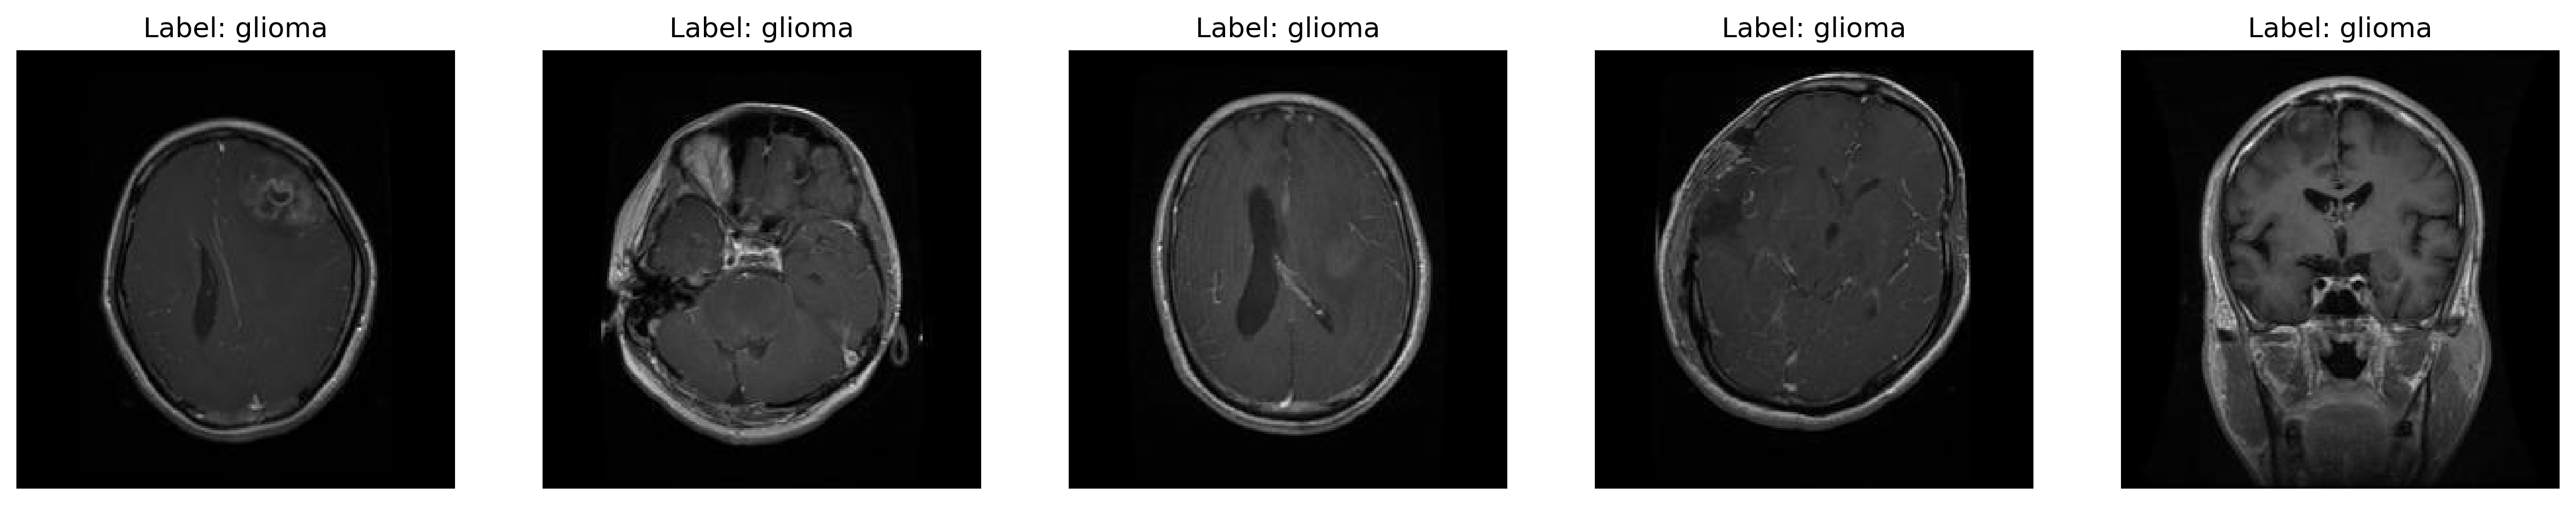

In [5]:
# Load and preprocess data
def load_data(image_folder, categories, image_size=(224, 224), log_file="load_data_log.txt"):
    data = []
    labels = []
    load_log = []
    for category in categories:
        folder_path = os.path.join(image_folder, category)
        class_num = categories.index(category)
        for img in os.listdir(folder_path):
            try:
                img_path = os.path.join(folder_path, img)
                img = Image.open(img_path).convert('RGB')  # Ensure all images are RGB
                original_size = img.size
                img = img.resize(image_size)
                img_array = np.array(img)
                data.append(img_array)
                labels.append(class_num)
                load_log.append((img_path, original_size, img_array.shape, class_num))
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    # Save log to file
    with open(log_file, 'w') as log:
        log.write("Loaded Images Log\n")
        log.write("Filepath\tOriginal Size\tNew Size\tLabel\n")
        for entry in load_log:
            log.write(f"{entry[0]}\t{entry[1]}\t{entry[2]}\t{entry[3]}\n")

    return np.array(data), np.array(labels)

# Example usage
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
data, labels = load_data(DATA_ROOT_DIR, categories)
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

# Print a sample of loaded data
print("Sample of loaded images and labels:")
for i in range(5):  # Print first 5 entries as proof
    print(f"Image shape: {data[i].shape}, Label: {labels[i]}")

# Display a few loaded images
def display_loaded_images(images, labels, categories, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {categories[labels[i]]}")
        axes[i].axis('off')
    plt.show()

display_loaded_images(data, labels, categories, num_images=5)

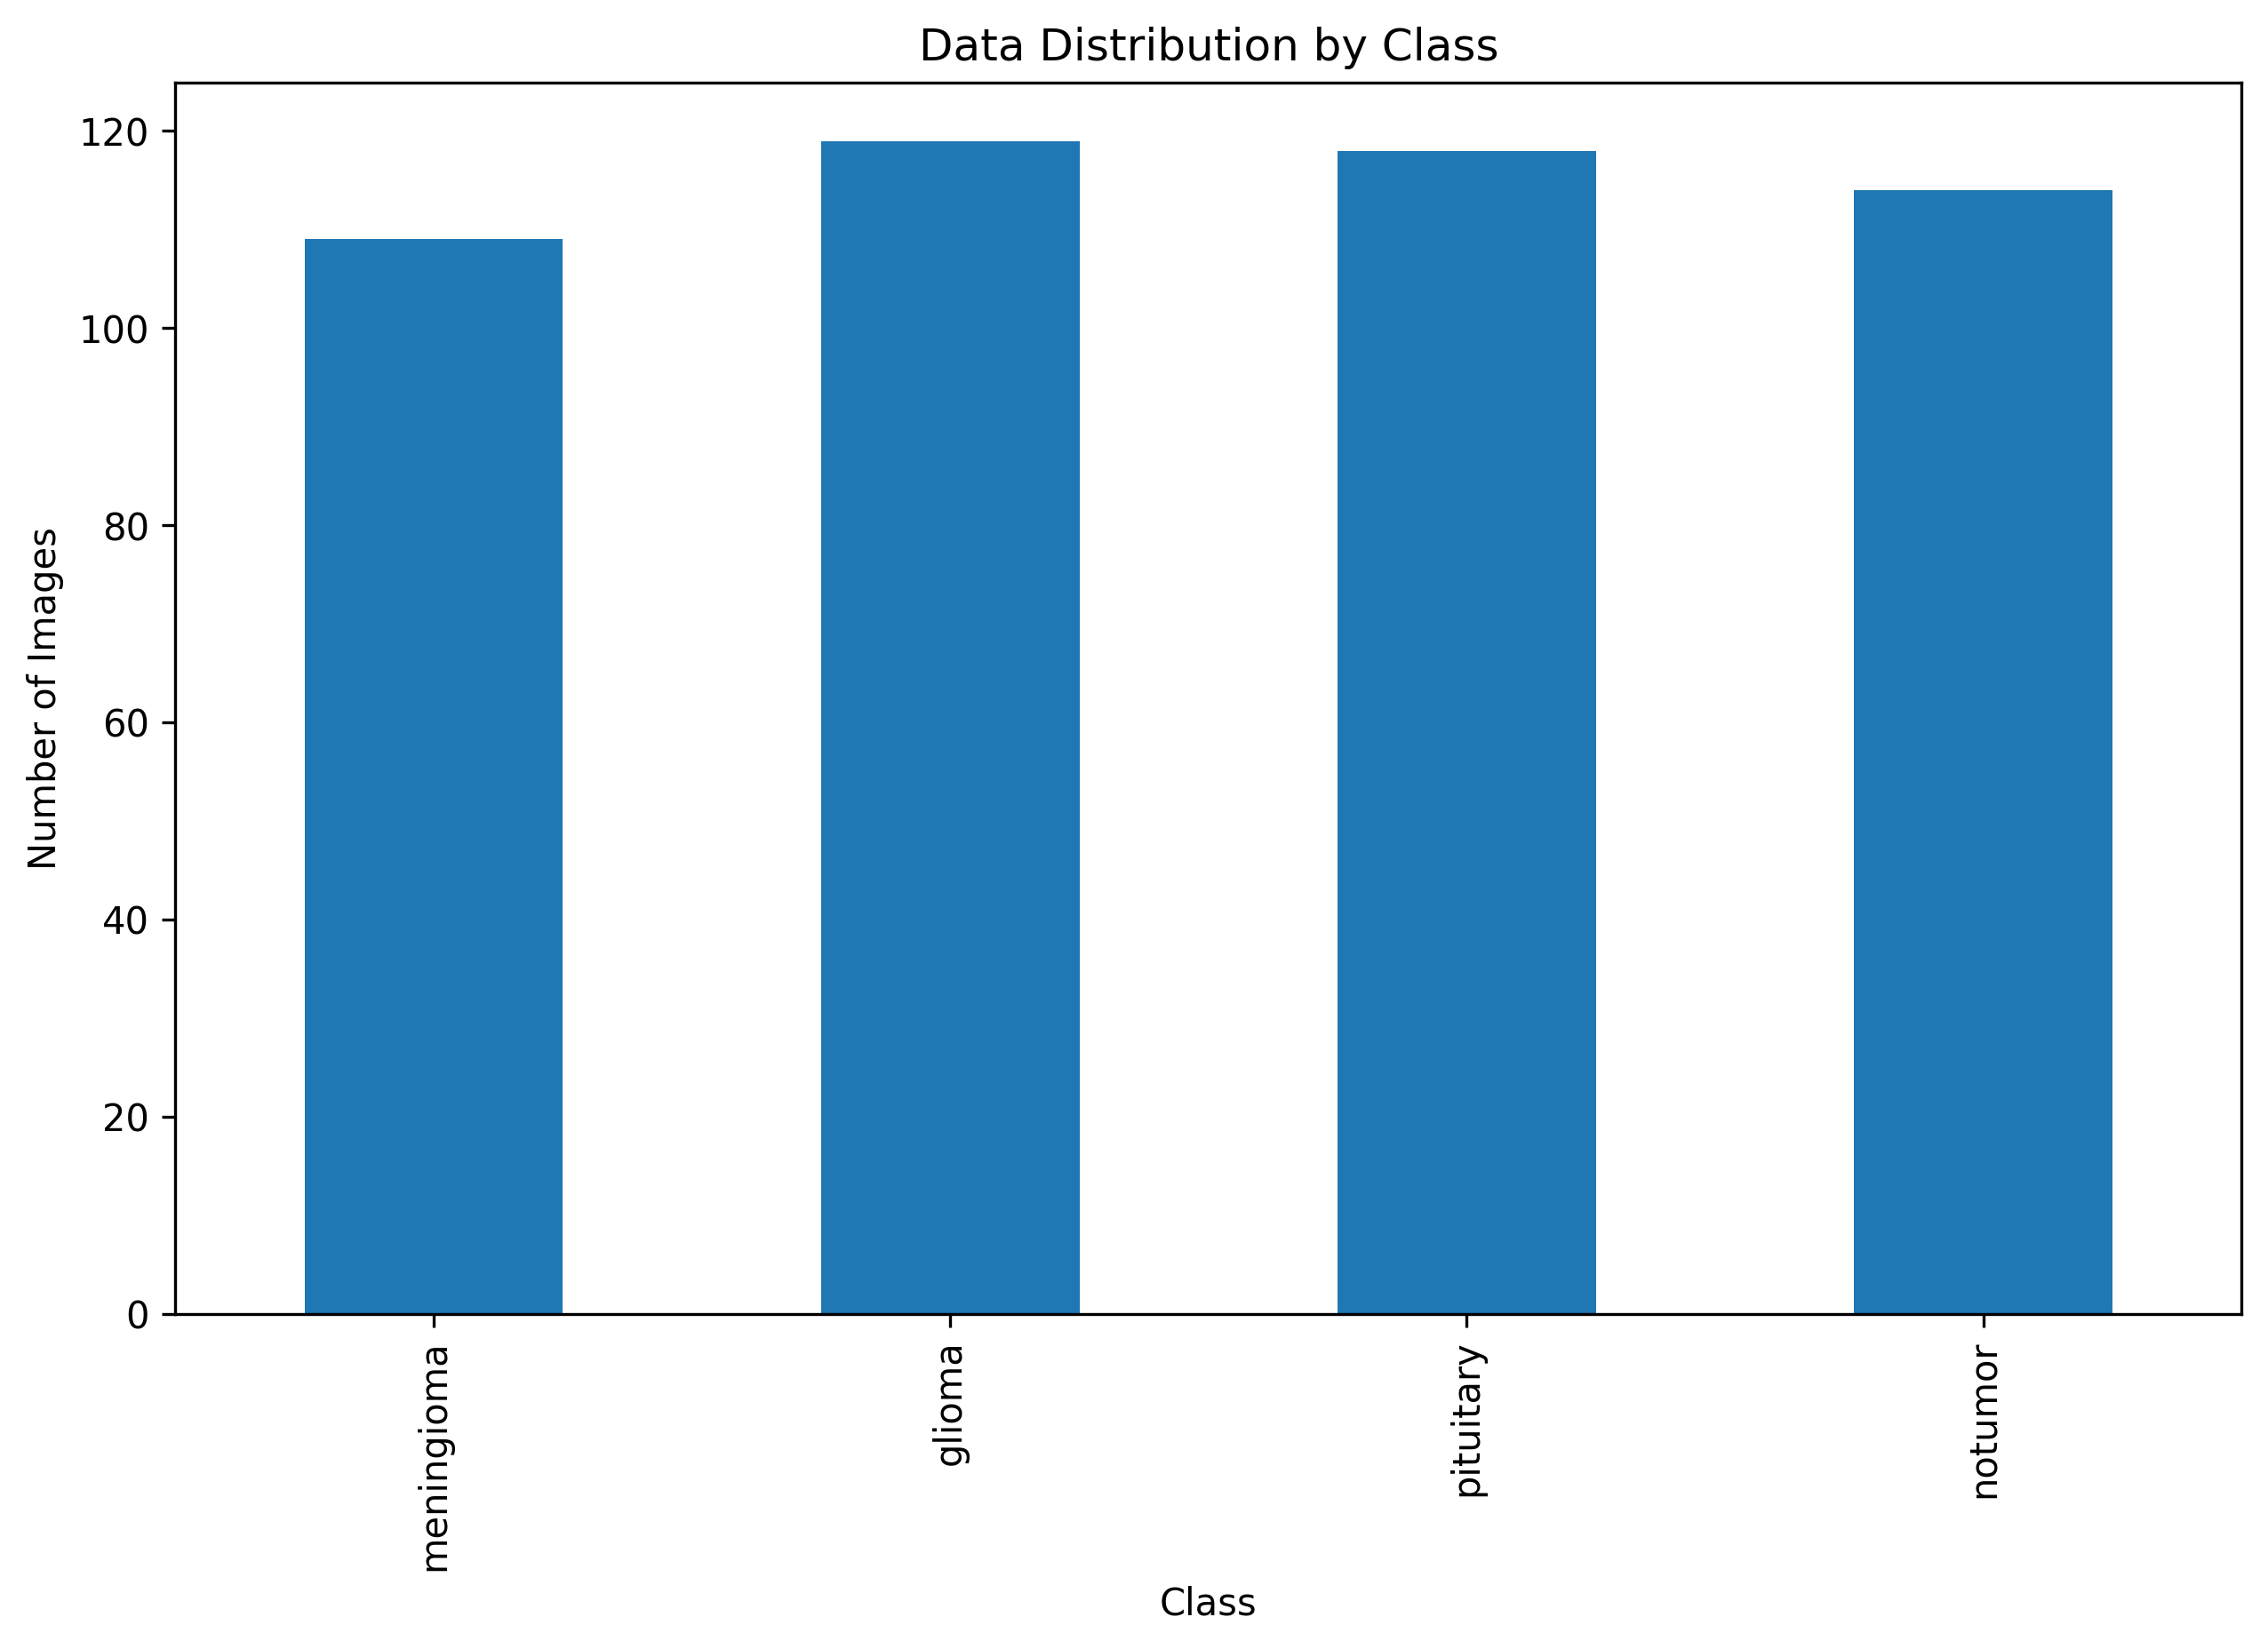

Data Distribution by Class:
meningioma: 109 images
glioma: 119 images
pituitary: 118 images
notumor: 114 images


In [6]:
# Data distribution visualization
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS], index=TUMOR_CLASSES)
data_distribution_count.plot(kind='bar', figsize=(10, 6), title="Data Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

print("Data Distribution by Class:")
for tumor_class, count in data_distribution_count.items():
    print(f"{tumor_class}: {count} images")

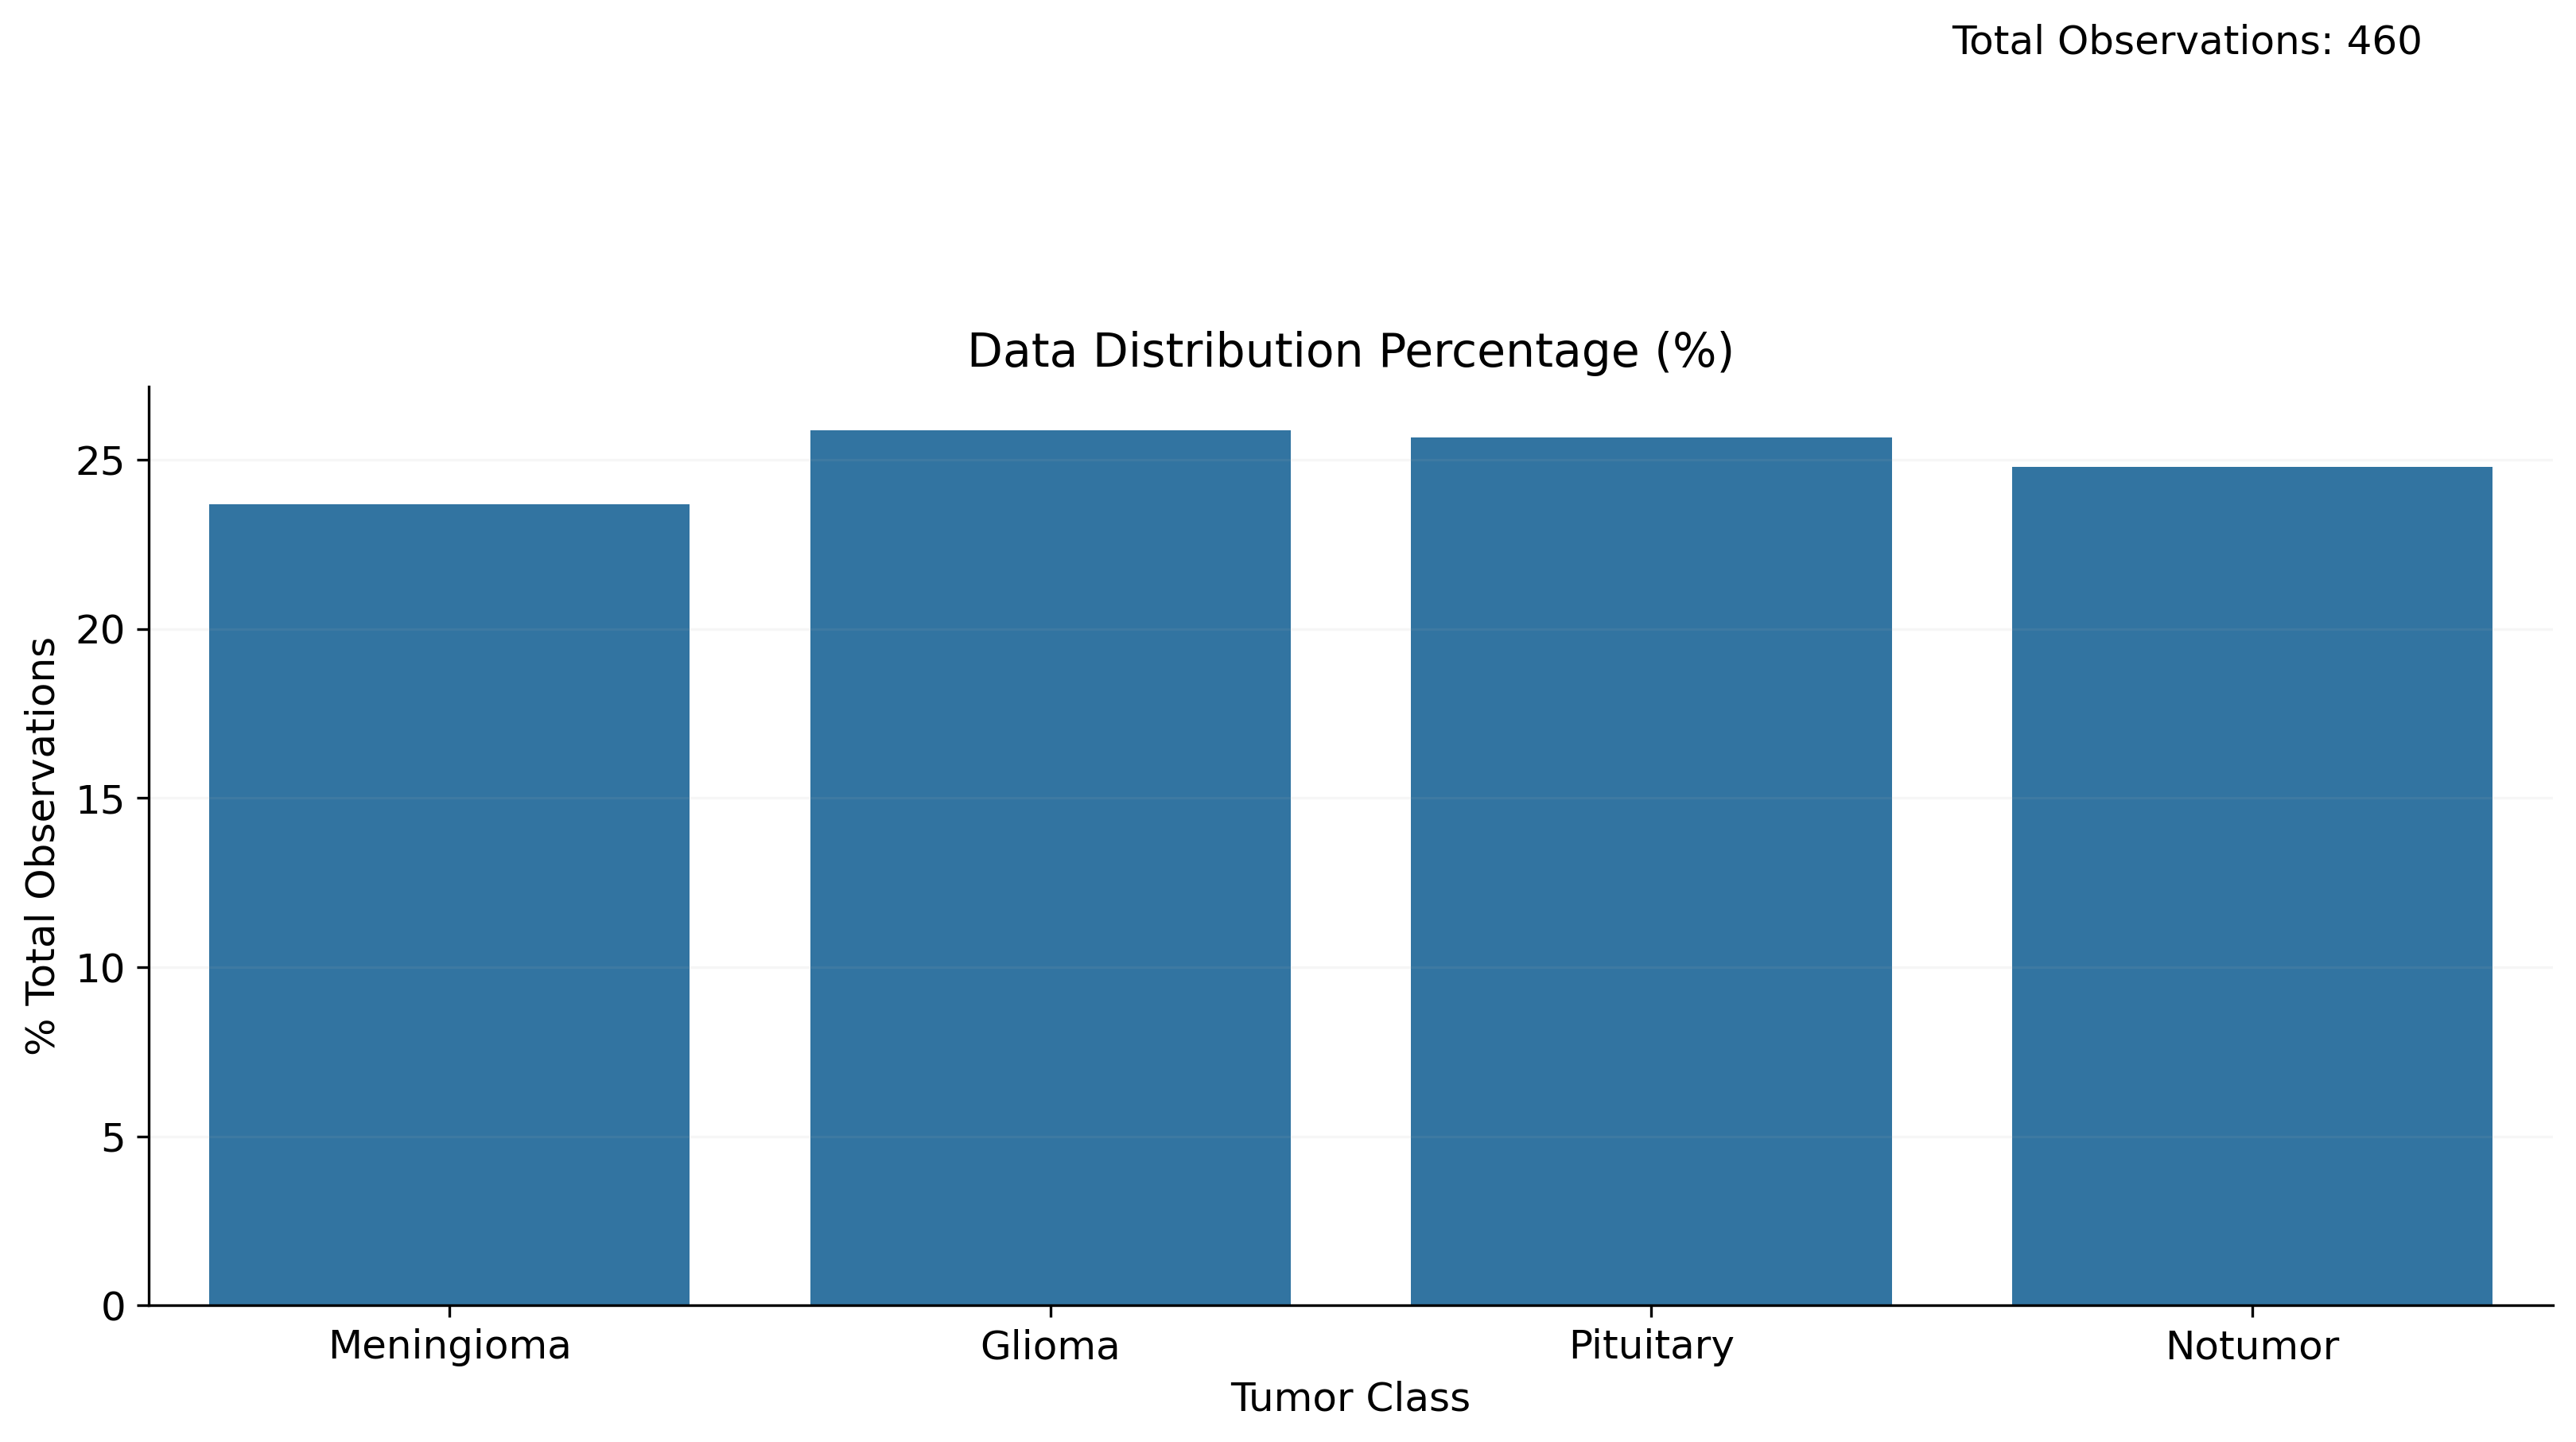

In [7]:
# Data Distribution Visualization
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * (data_distribution_count / data_distribution_count.sum()), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

plt.show()

In [8]:
# Remove duplicate images
def remove_duplicates(image_folder):
    hash_keys = dict()
    duplicates = []

    for root, dirs, files in os.walk(image_folder):
        for filename in files:
            if filename.endswith(".png") or filename.endswith(".jpg"):
                filepath = os.path.join(root, filename)
                try:
                    with Image.open(filepath) as img:
                        img_hash = hashlib.md5(img.tobytes()).hexdigest()
                        if img_hash not in hash_keys:
                            hash_keys[img_hash] = filename
                        else:
                            duplicates.append(filepath)
                except Exception as e:
                    print(f"Error processing file {filepath}: {e}")

    for duplicate in duplicates:
        os.remove(duplicate)

    return duplicates

# Example usage
duplicates = remove_duplicates(DATA_ROOT_DIR)
duplicates_count = len(duplicates)
print(f"Removed {duplicates_count} duplicate images.")
print("List of removed duplicate images:")
for dup in duplicates:
    print(dup)

# Optionally, save the list of removed duplicates to a file
log_file_path = os.path.join(ROOT_DIR, "removed_duplicates_log.txt")
with open(log_file_path, 'w') as log_file:
    log_file.write(f"Removed {duplicates_count} duplicate images.\n")
    log_file.write("List of removed duplicate images:\n")
    for dup in duplicates:
        log_file.write(f"{dup}\n")

Removed 0 duplicate images.
List of removed duplicate images:


In [9]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASSES)
data_distribution_count

meningioma    109
glioma        119
pituitary     118
notumor       114
dtype: int64

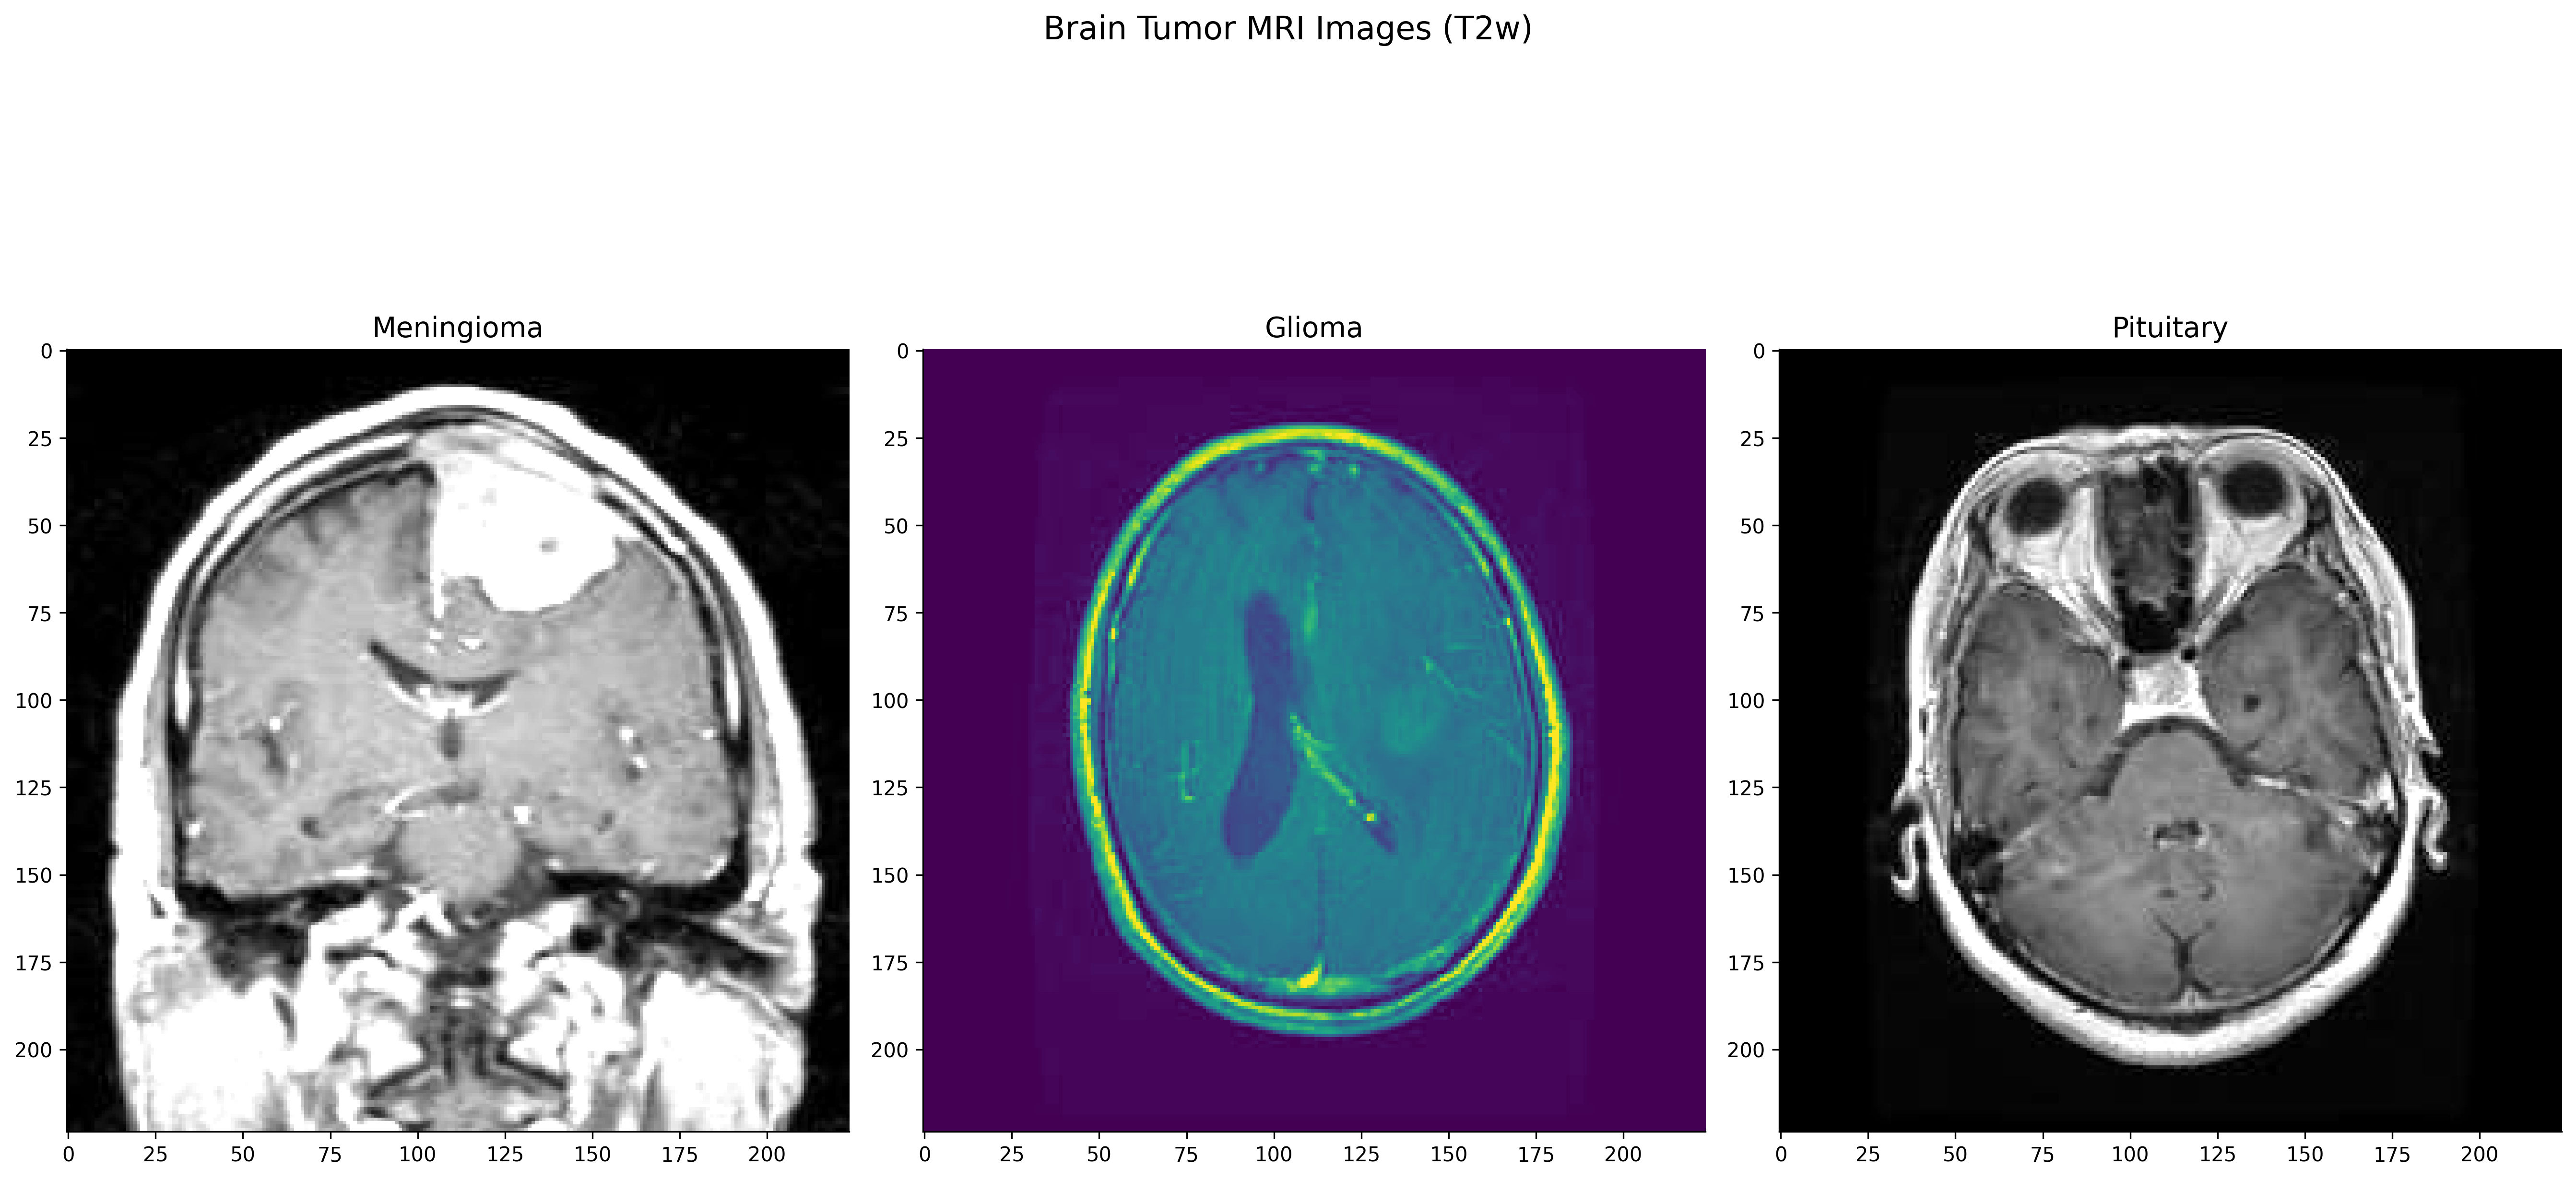

In [10]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)

for curr_title, filename, curr_axis in zip(TUMOR_CLASSES[:-1], IMAGE_DATA_PATHS[:-1], axes):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

fig.tight_layout()
sns.despine()


In [11]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASSES):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [12]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

image_filepaths tumor_class
0  /Users/halimsmacbookairm1/Documents/GitHub/csc...      glioma
1  /Users/halimsmacbookairm1/Documents/GitHub/csc...  meningioma
2  /Users/halimsmacbookairm1/Documents/GitHub/csc...      glioma
3  /Users/halimsmacbookairm1/Documents/GitHub/csc...     notumor
4  /Users/halimsmacbookairm1/Documents/GitHub/csc...      glioma

In [13]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  460 non-null    object
 1   tumor_class      460 non-null    object
dtypes: object(2)
memory usage: 7.3+ KB


In [14]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df,
                                                      train_size = 0.70,
                                                      random_state = 42,
                                                      stratify = image_data_paths_df.tumor_class)

train_data, validation_data = train_test_split(intermediate_train_data,
                                               train_size = 0.80,
                                               random_state = 42,
                                               stratify = intermediate_train_data.tumor_class)

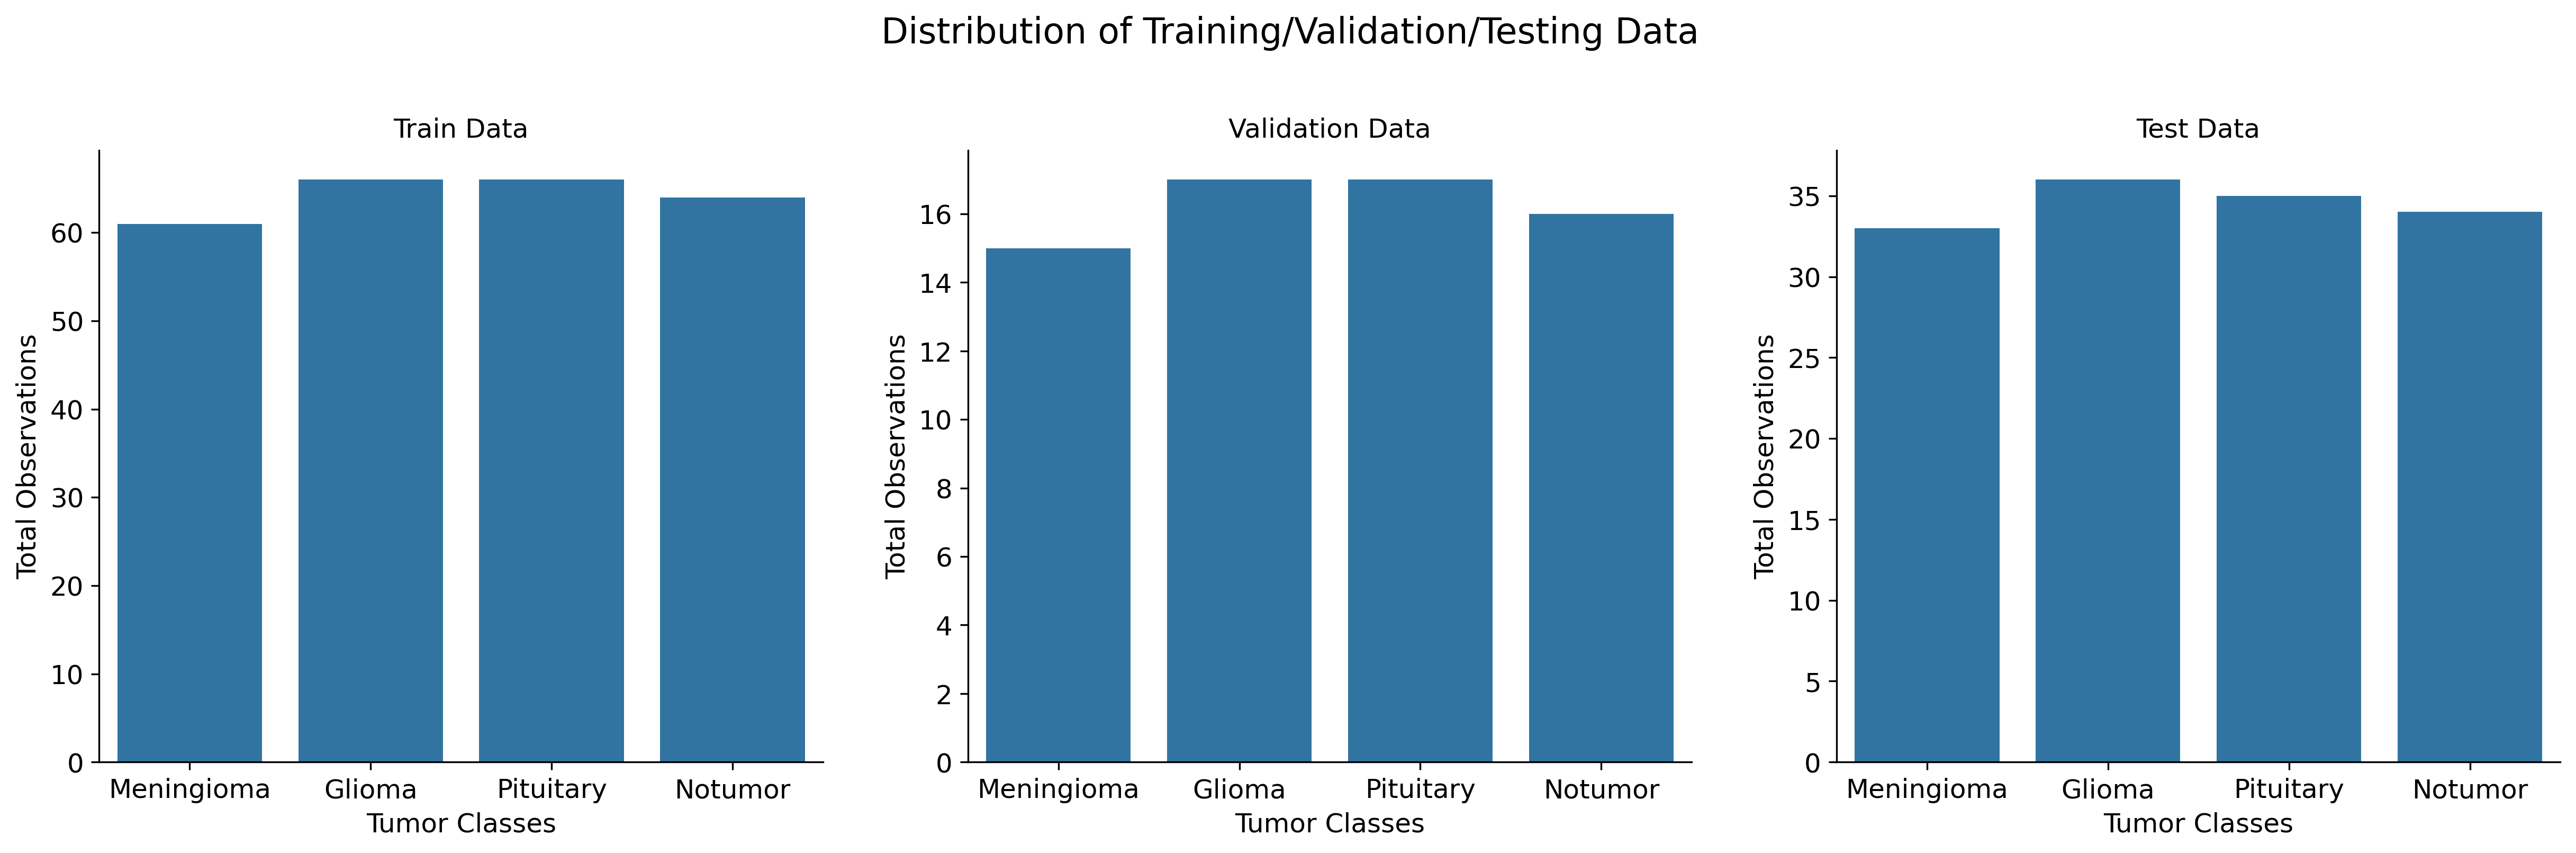

In [15]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)

sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASSES, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASSES, ax = axes[1])
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASSES, ax = axes[2])

for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False)  # Disable the grid without additional properties
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    
    curr_axis.set_xticks(range(len(TUMOR_CLASSES)))  # Set the number of ticks
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASSES])

sns.despine()

Resized all images to 224x224.
Sample of resized images:
File: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/pituitary/Tr-pi_0075.jpg, Original Size: (224, 224), New Size: (224, 224)
File: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/pituitary/Tr-pi_0049.jpg, Original Size: (224, 224), New Size: (224, 224)
File: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/pituitary/Te-pi_0019.jpg, Original Size: (224, 224), New Size: (224, 224)
File: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/pituitary/Te-pi_0031.jpg, Original Size: (224, 224), New Size: (224, 224)
File: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/dataset_26/pituitary/Tr-pi_0101.jpg, Original Si

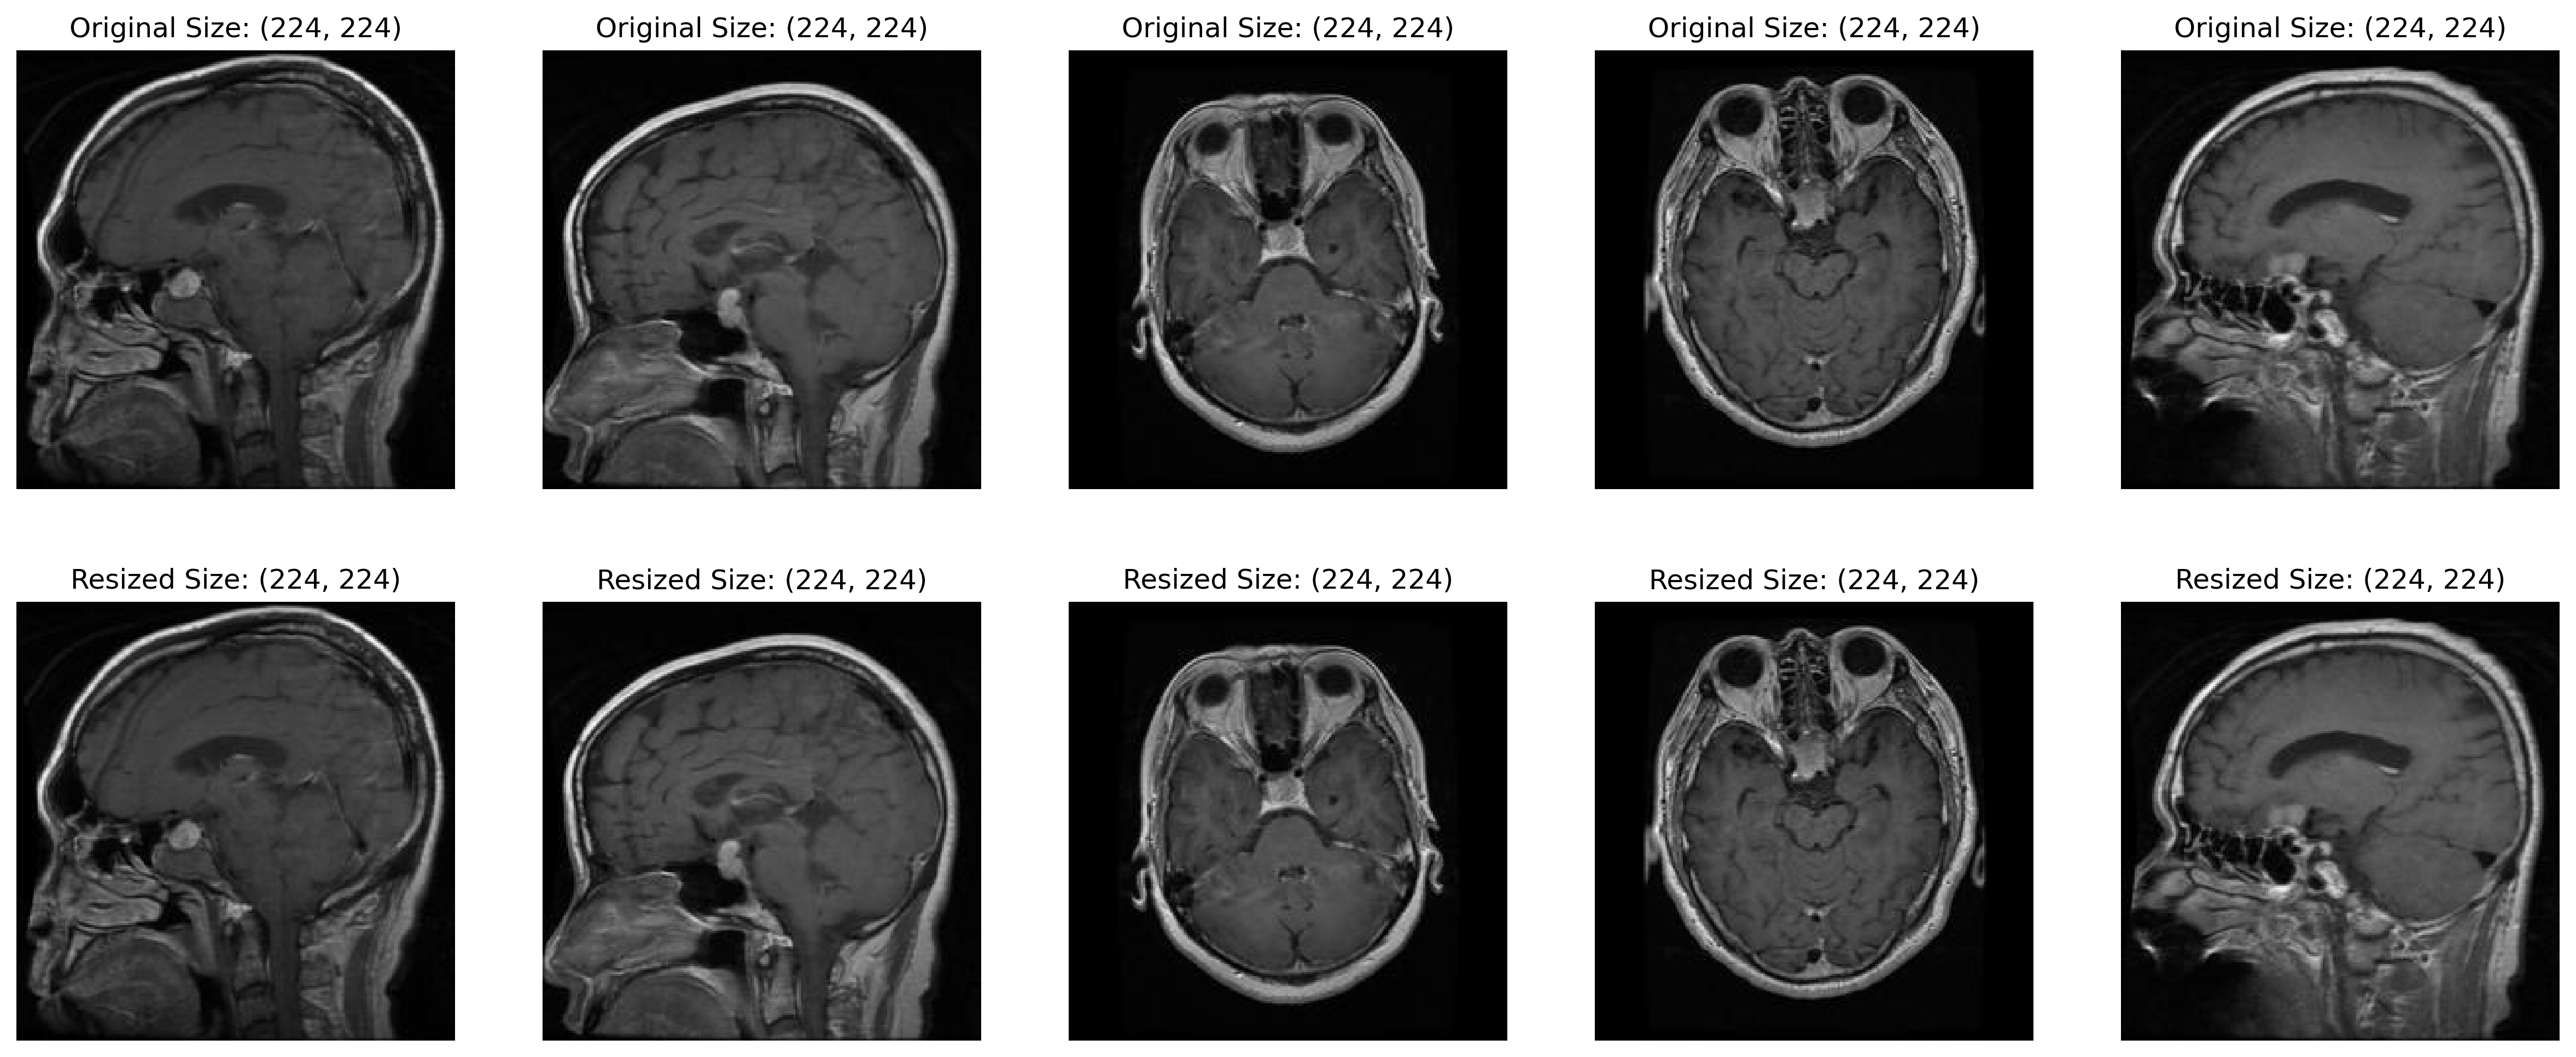

In [16]:
# Normalize image shapes
def resize_images(image_folder, target_size=(224, 224), log_file="resize_log.txt"):
    resize_log = []
    for root, dirs, files in os.walk(image_folder):
        for filename in files:
            if filename.endswith(".png") or filename.endswith(".jpg"):
                filepath = os.path.join(root, filename)
                with Image.open(filepath) as img:
                    original_size = img.size
                    img_resized = img.resize(target_size)
                    img_resized.save(filepath)
                    resize_log.append((filepath, original_size, img_resized.size))

    # Save log to file
    with open(log_file, 'w') as log:
        log.write("Resized Images Log\n")
        log.write("Filepath\tOriginal Size\tNew Size\n")
        for entry in resize_log:
            log.write(f"{entry[0]}\t{entry[1]}\t{entry[2]}\n")

    return resize_log

# Example usage
resize_log = resize_images(DATA_ROOT_DIR)
print("Resized all images to 224x224.")
print("Sample of resized images:")
for entry in resize_log[:5]:  # Show first 5 entries as proof
    print(f"File: {entry[0]}, Original Size: {entry[1]}, New Size: {entry[2]}")

# Display a few images before and after resizing
def display_image_comparison(image_paths, target_size=(224, 224)):
    fig, axes = plt.subplots(2, len(image_paths), figsize=(20, 8))
    for i, image_path in enumerate(image_paths):
        with Image.open(image_path) as img:
            axes[0, i].imshow(img)
            axes[0, i].set_title(f"Original Size: {img.size}")
            axes[0, i].axis('off')
            img_resized = img.resize(target_size)
            axes[1, i].imshow(img_resized)
            axes[1, i].set_title(f"Resized Size: {img_resized.size}")
            axes[1, i].axis('off')
    plt.show()

# Select a few images to display as proof
sample_image_paths = [entry[0] for entry in resize_log[:5]]  # Use first 5 entries for display
display_image_comparison(sample_image_paths)

In [17]:
# Image size and batch size
image_size = 128
batch_size = 32

# Define data augmentation and data generators
image_datagen_kwargs = dict(
    rescale=1/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.01,
    brightness_range=[0.3, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [18]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(rescale=1/255)
test_image_datagen = ImageDataGenerator(rescale=1/255)

In [19]:
train_dataset = train_image_datagen.flow_from_dataframe(
    train_data,
    x_col='image_filepaths',
    y_col='tumor_class',
    seed=42,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    class_mode='categorical',
    color_mode='rgb'
)

validation_dataset = validation_image_datagen.flow_from_dataframe(
    validation_data,
    x_col='image_filepaths',
    y_col='tumor_class',
    seed=42,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    class_mode='categorical',
    color_mode='rgb'
)

test_dataset = test_image_datagen.flow_from_dataframe(
    test_data,
    x_col='image_filepaths',
    y_col='tumor_class',
    seed=42,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    class_mode='categorical',
    color_mode='rgb'
)

Found 257 validated image filenames belonging to 4 classes.
Found 65 validated image filenames belonging to 4 classes.
Found 138 validated image filenames belonging to 4 classes.


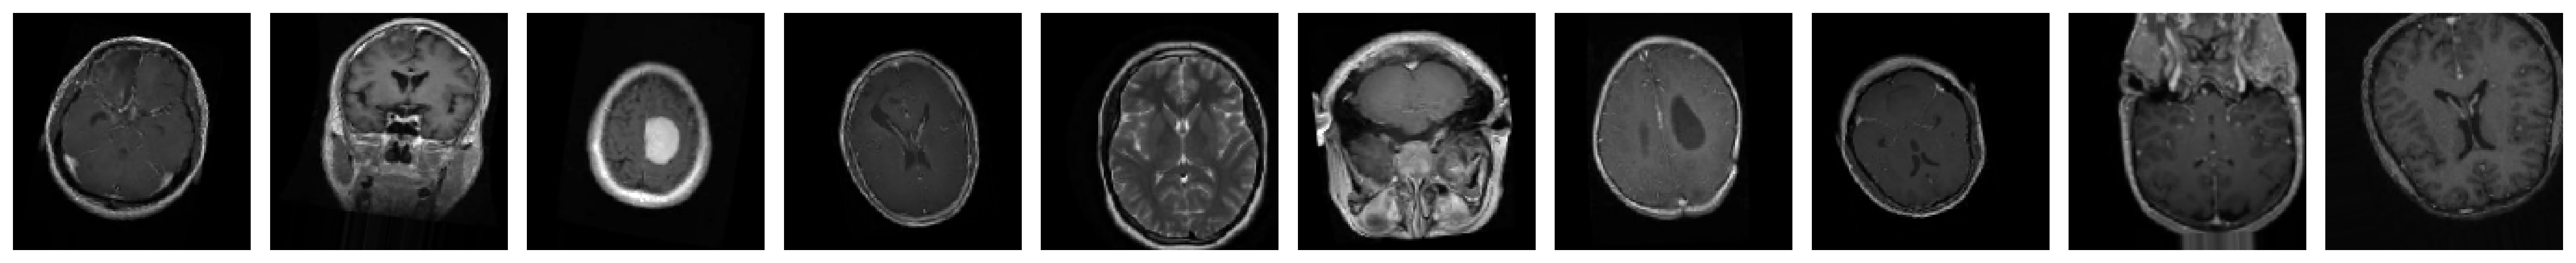

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
(128, 128, 3)


In [20]:
# Visualize Data Augmentation
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of augmented images
augmented_images, _ = next(train_dataset)

# Plot augmented images
plot_images(augmented_images[:10])

print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end='\n\n')

print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end='\n\n')

print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

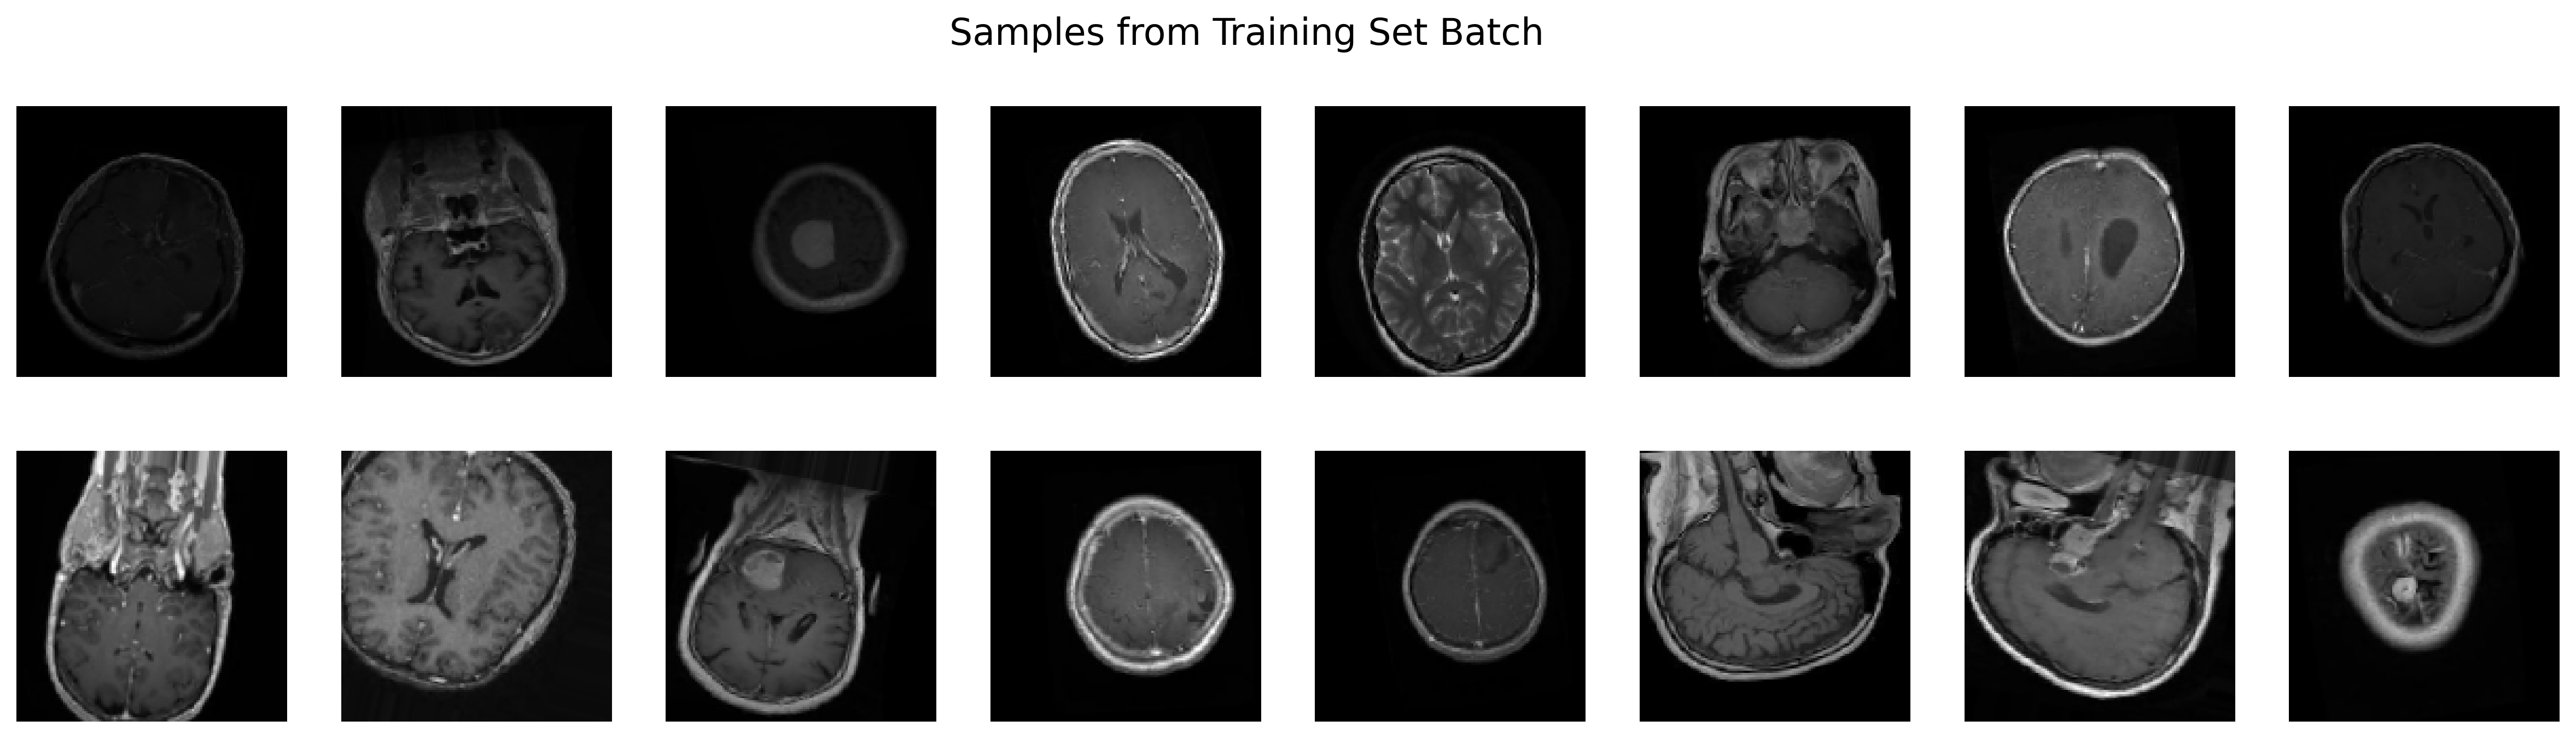

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize=16, fontdict=dict(weight='bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap='gray')
    curr_axis.axis(False)

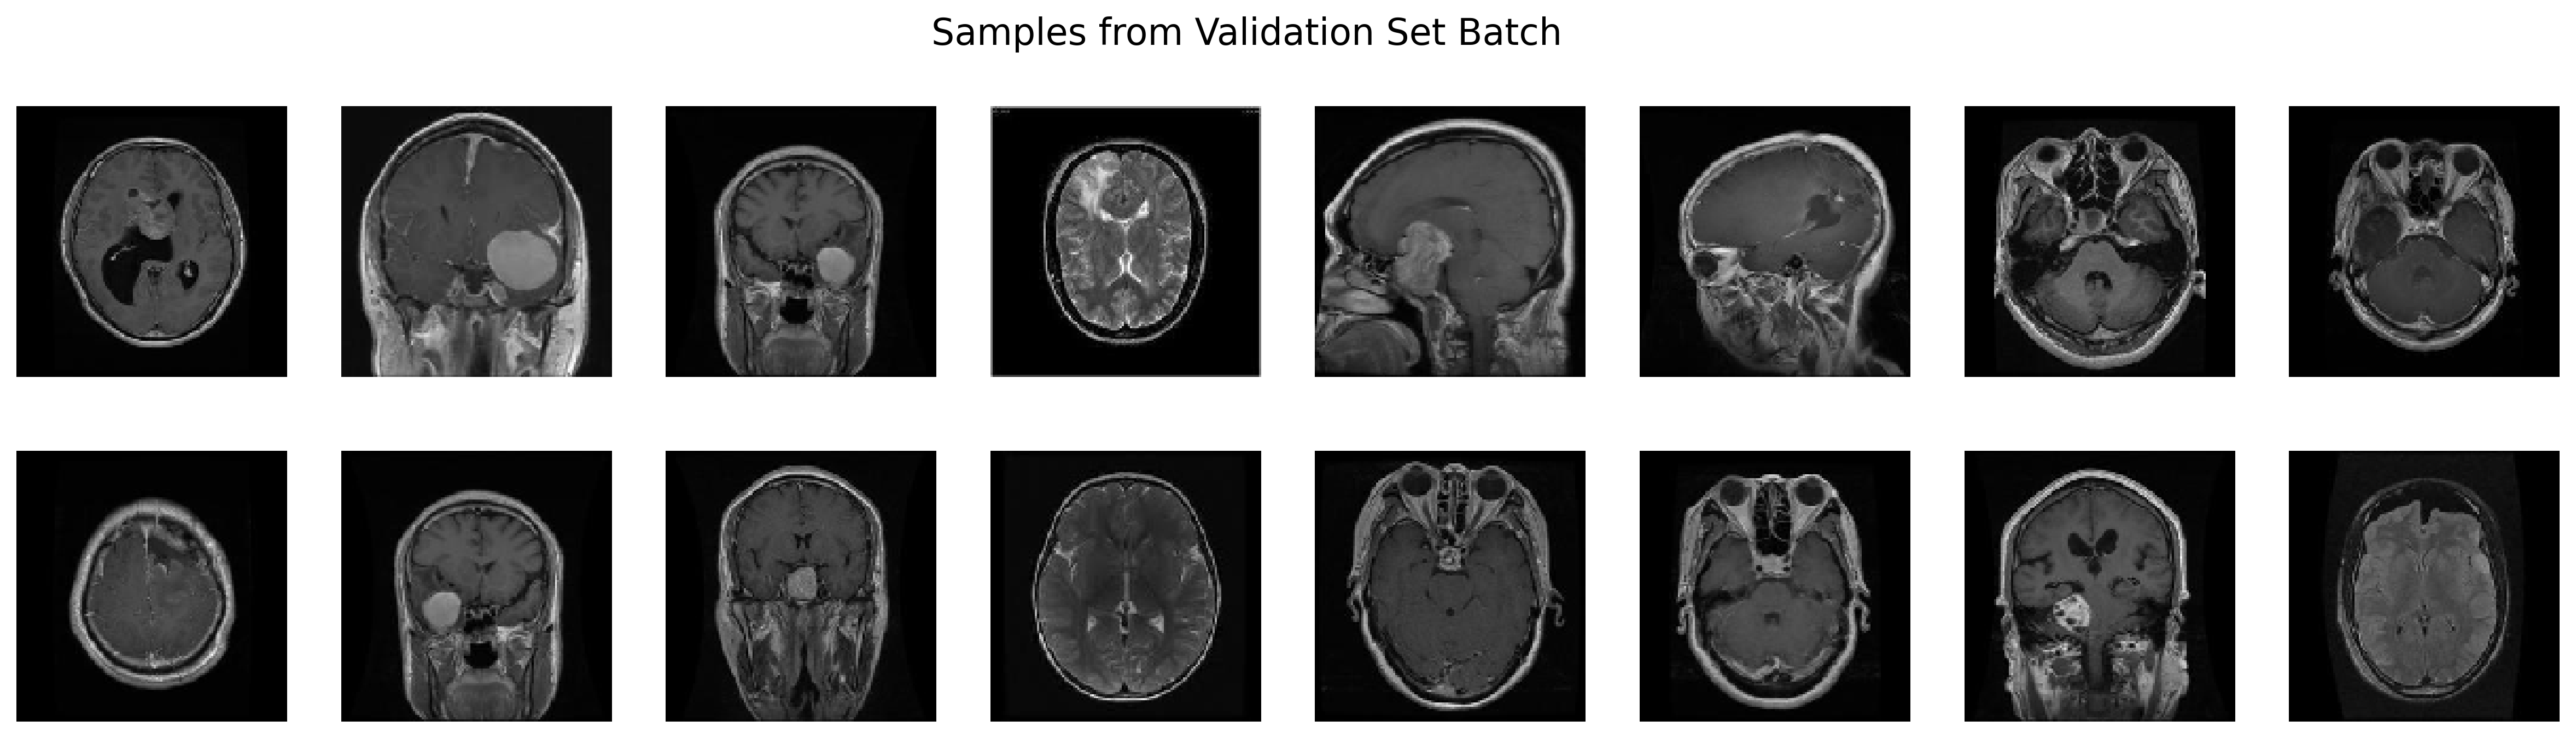

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize=16, fontdict=dict(weight='bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap='gray')
    curr_axis.axis(False)

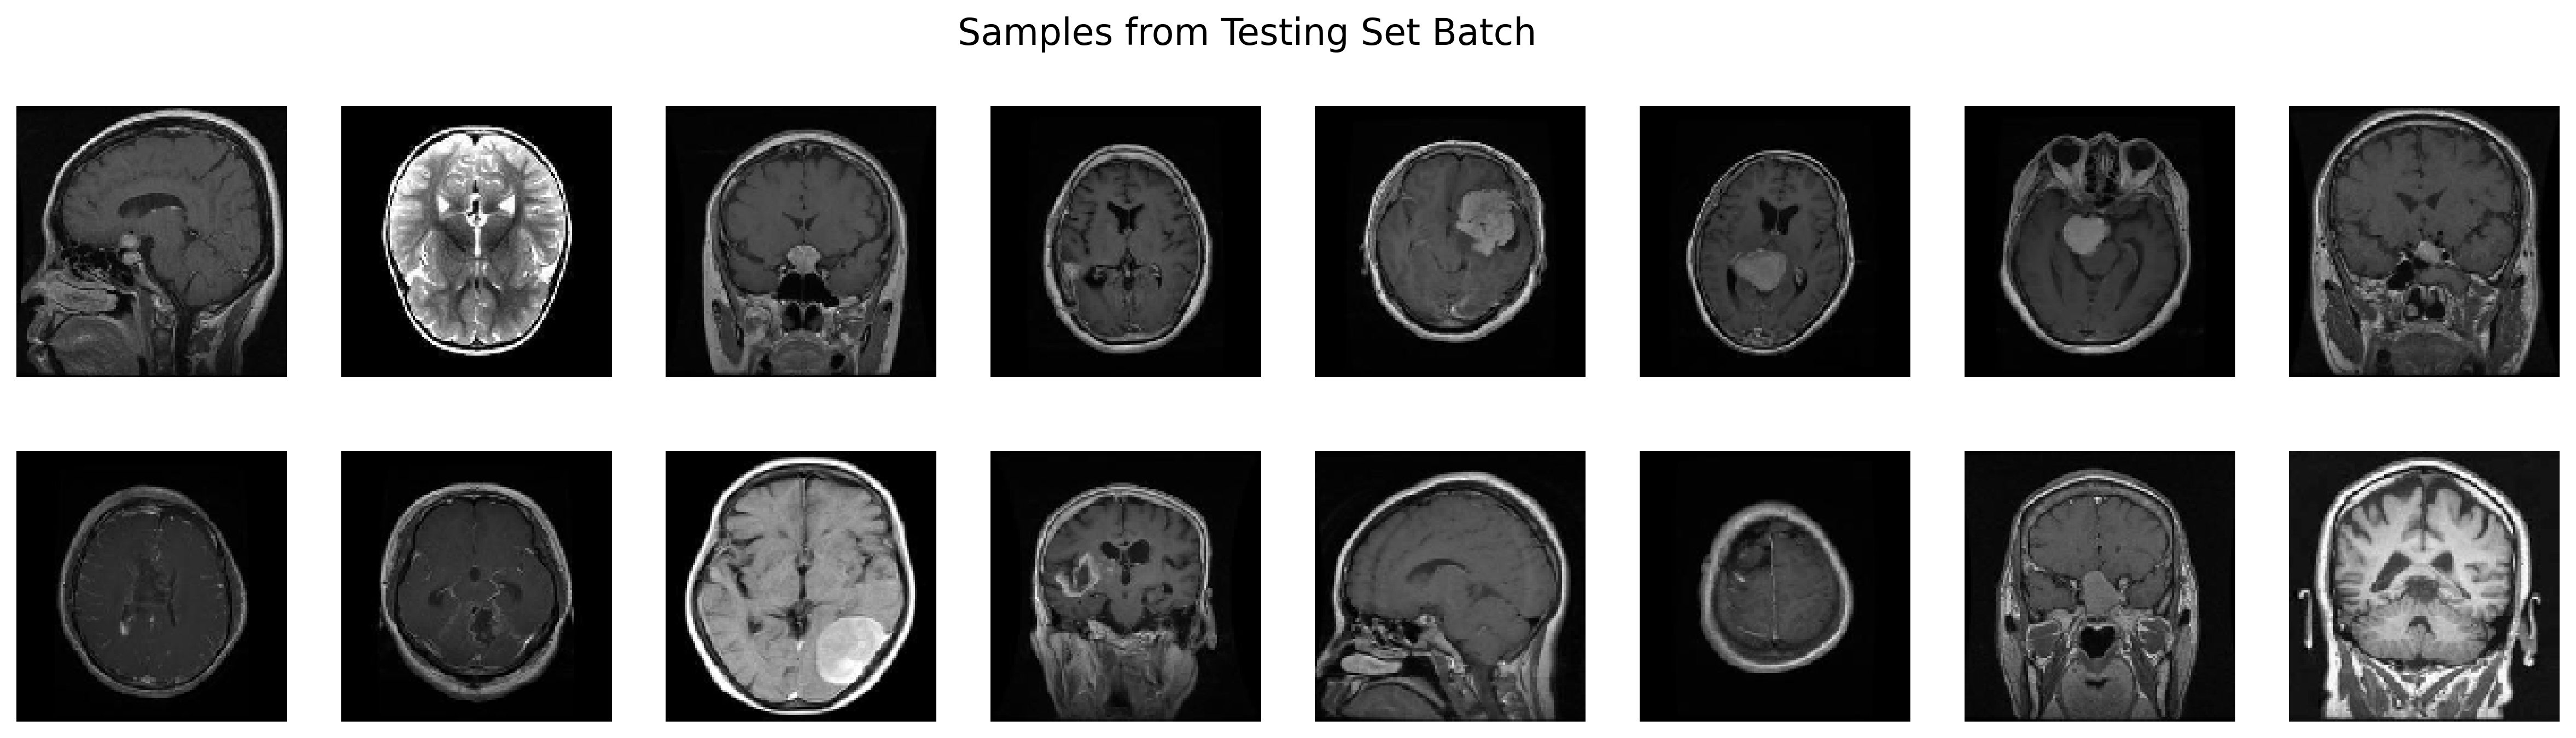

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize=16, fontdict=dict(weight='bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap='gray')
    curr_axis.axis(False)

In [24]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [25]:
# Define the root directory for checkpoints
ROOT_DIR = "/Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim"
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")

# Define specific directory for InceptionV3
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")

# Ensure the directory exists
os.makedirs(INCEPTIONV3_CHECKPOINT_DIR_PATH, exist_ok=True)

# Define the checkpoint file path for InceptionV3
INCEPTIONV3_CHECKPOINT_FILE_PATH = os.path.join(INCEPTIONV3_CHECKPOINT_DIR_PATH, "inceptionv3_weights.weights.h5")

# Print the checkpoint file path to verify
print("Checkpoint File Path:", INCEPTIONV3_CHECKPOINT_FILE_PATH)

Checkpoint File Path: /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/Model-Checkpoints/InceptionV3/inceptionv3_weights.weights.h5


In [26]:
inceptionv3_cp_callback = ModelCheckpoint(
    filepath=INCEPTIONV3_CHECKPOINT_FILE_PATH,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

In [27]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize=16, fontdict=dict(weight='bold'), y=1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha=0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize=14)
        sns.lineplot(x=range(1, 1 + training_stats.shape[0]), y=training_stats[col_name], color='blue', ax=curr_axis)
        sns.lineplot(x=range(1, 1 + training_stats.shape[0]), y=training_stats[f"val_{col_name}"], color='red', ax=curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize=12)
        curr_axis.set_ylabel(col_name.title(), fontsize=12)
        curr_axis.tick_params(which='major', labelsize=12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title=col_name.title())
    fig.tight_layout()
    sns.despine()

In [28]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize=(8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot=True, cmap=plt.cm.Reds, ax=axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize=14)
    axis.tick_params(which='major', labelsize=12)
    axis.set_xlabel("Predicted Class", fontsize=12)
    axis.set_ylabel("Actual Class", fontsize=12)
    axis.set_xticklabels(class_names, fontdict=dict(fontsize=12))
    axis.set_yticklabels(class_names, fontdict=dict(fontsize=12))
    fig.tight_layout()
    sns.despine()

In [29]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes  # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), root_mean_squared_error(y_hat, y_preds), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average="micro")]
    report_df.index = row_indexes
    return report_df

In [30]:
# Load InceptionV3 model without the top layer
inception_v3_model = InceptionV3(include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')
inception_v3_model.trainable = False

In [31]:
# Build the Sequential model
inception_cnn_model = Sequential([
    Input(shape=(image_size, image_size, 3)),
    inception_v3_model,
    Flatten(),
    Dense(1024, activation='relu', name='Hidden-Layer-1'),
    Dense(4, activation='softmax', name='Output-Layer')
])

# Compile the model
inception_cnn_model.compile(optimizer=Adam(learning_rate=0.0001), 
                            loss='categorical_crossentropy', 
                            metrics=['accuracy'])

# Force build model by running dummy data through it
dummy_data = tf.random.normal([1, image_size, image_size, 3])
_ = inception_cnn_model(dummy_data)

# Display model summary
inception_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-Layer-1 (Dense)          │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-Layer (Dense)            │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [32]:
# Check for GPU availability
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

# Train the model
with tf.device(device):
    inception_model_train_history = inception_cnn_model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=100,
        callbacks=[early_stopping, inceptionv3_cp_callback]
    )

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.2458 - loss: 10.6832
Epoch 1: saving model to /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/Model-Checkpoints/InceptionV3/inceptionv3_weights.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - accuracy: 0.2481 - loss: 10.6618 - val_accuracy: 0.2615 - val_loss: 14.3660
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4246 - loss: 5.9147
Epoch 2: saving model to /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/Model-Checkpoints/InceptionV3/inceptionv3_weights.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.4253 - loss: 5.8190 - val_accuracy: 0.6000 - val_loss: 0.7723
Epoch 3/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4803 - loss: 1.6161
Epoch 3: saving model to /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/

Epoch 19/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7810 - loss: 0.5301
Epoch 19: saving model to /Users/halimsmacbookairm1/Documents/GitHub/csc3107-group26-p3-ml-brain-mri-classification/research/Halim/Model-Checkpoints/InceptionV3/inceptionv3_weights.weights.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.7823 - loss: 0.5207 - val_accuracy: 0.6615 - val_loss: 0.8775


In [33]:
# Evaluate the model on test data
test_loss, test_accuracy = inception_cnn_model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6363 - loss: 1.1712
Test accuracy: 0.6666666865348816, Test loss: 1.0698330402374268


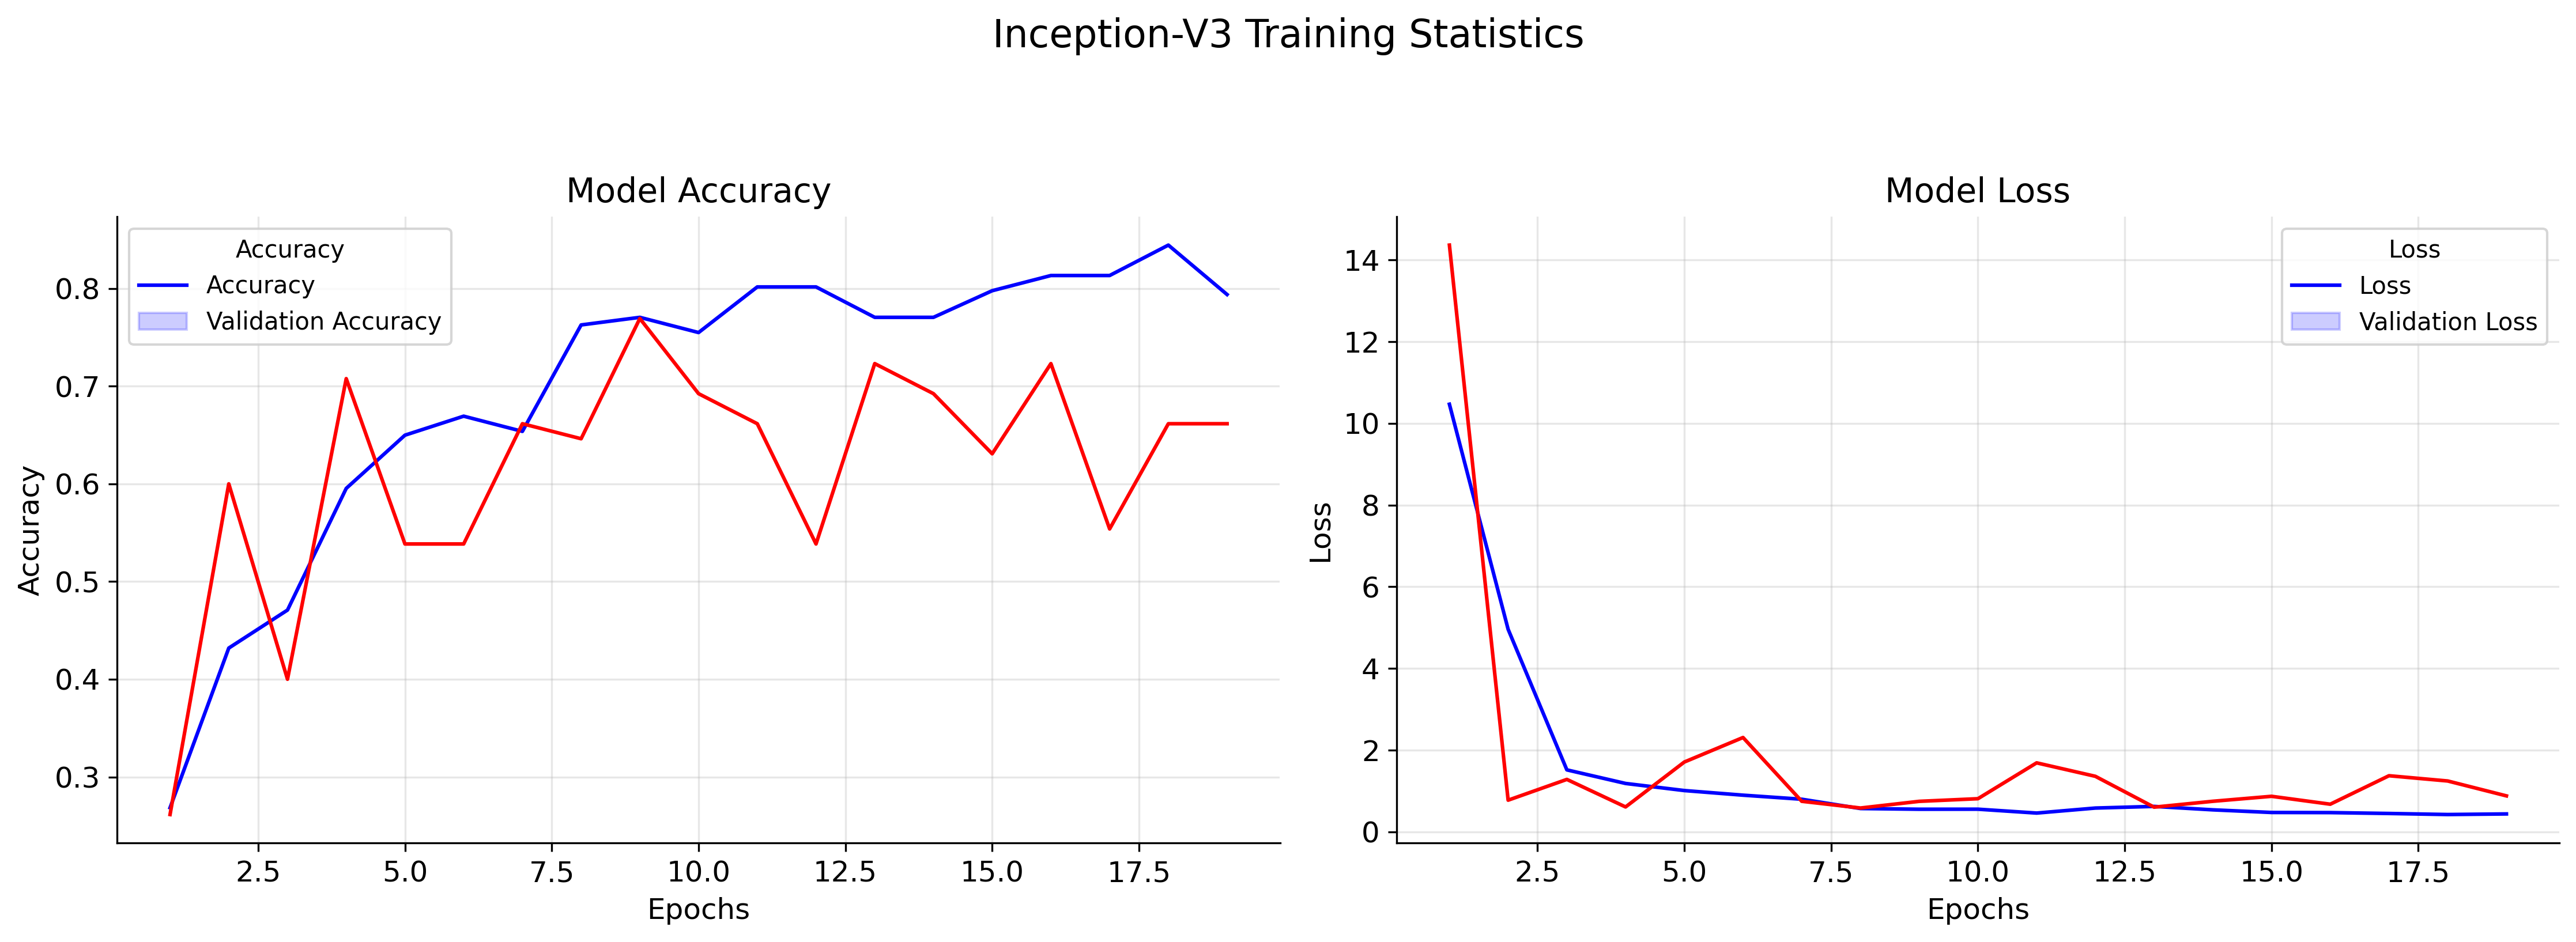

In [34]:
training_process_viz(pd.DataFrame(inception_model_train_history.history), plot_title='Inception-V3 Training Statistics')


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step


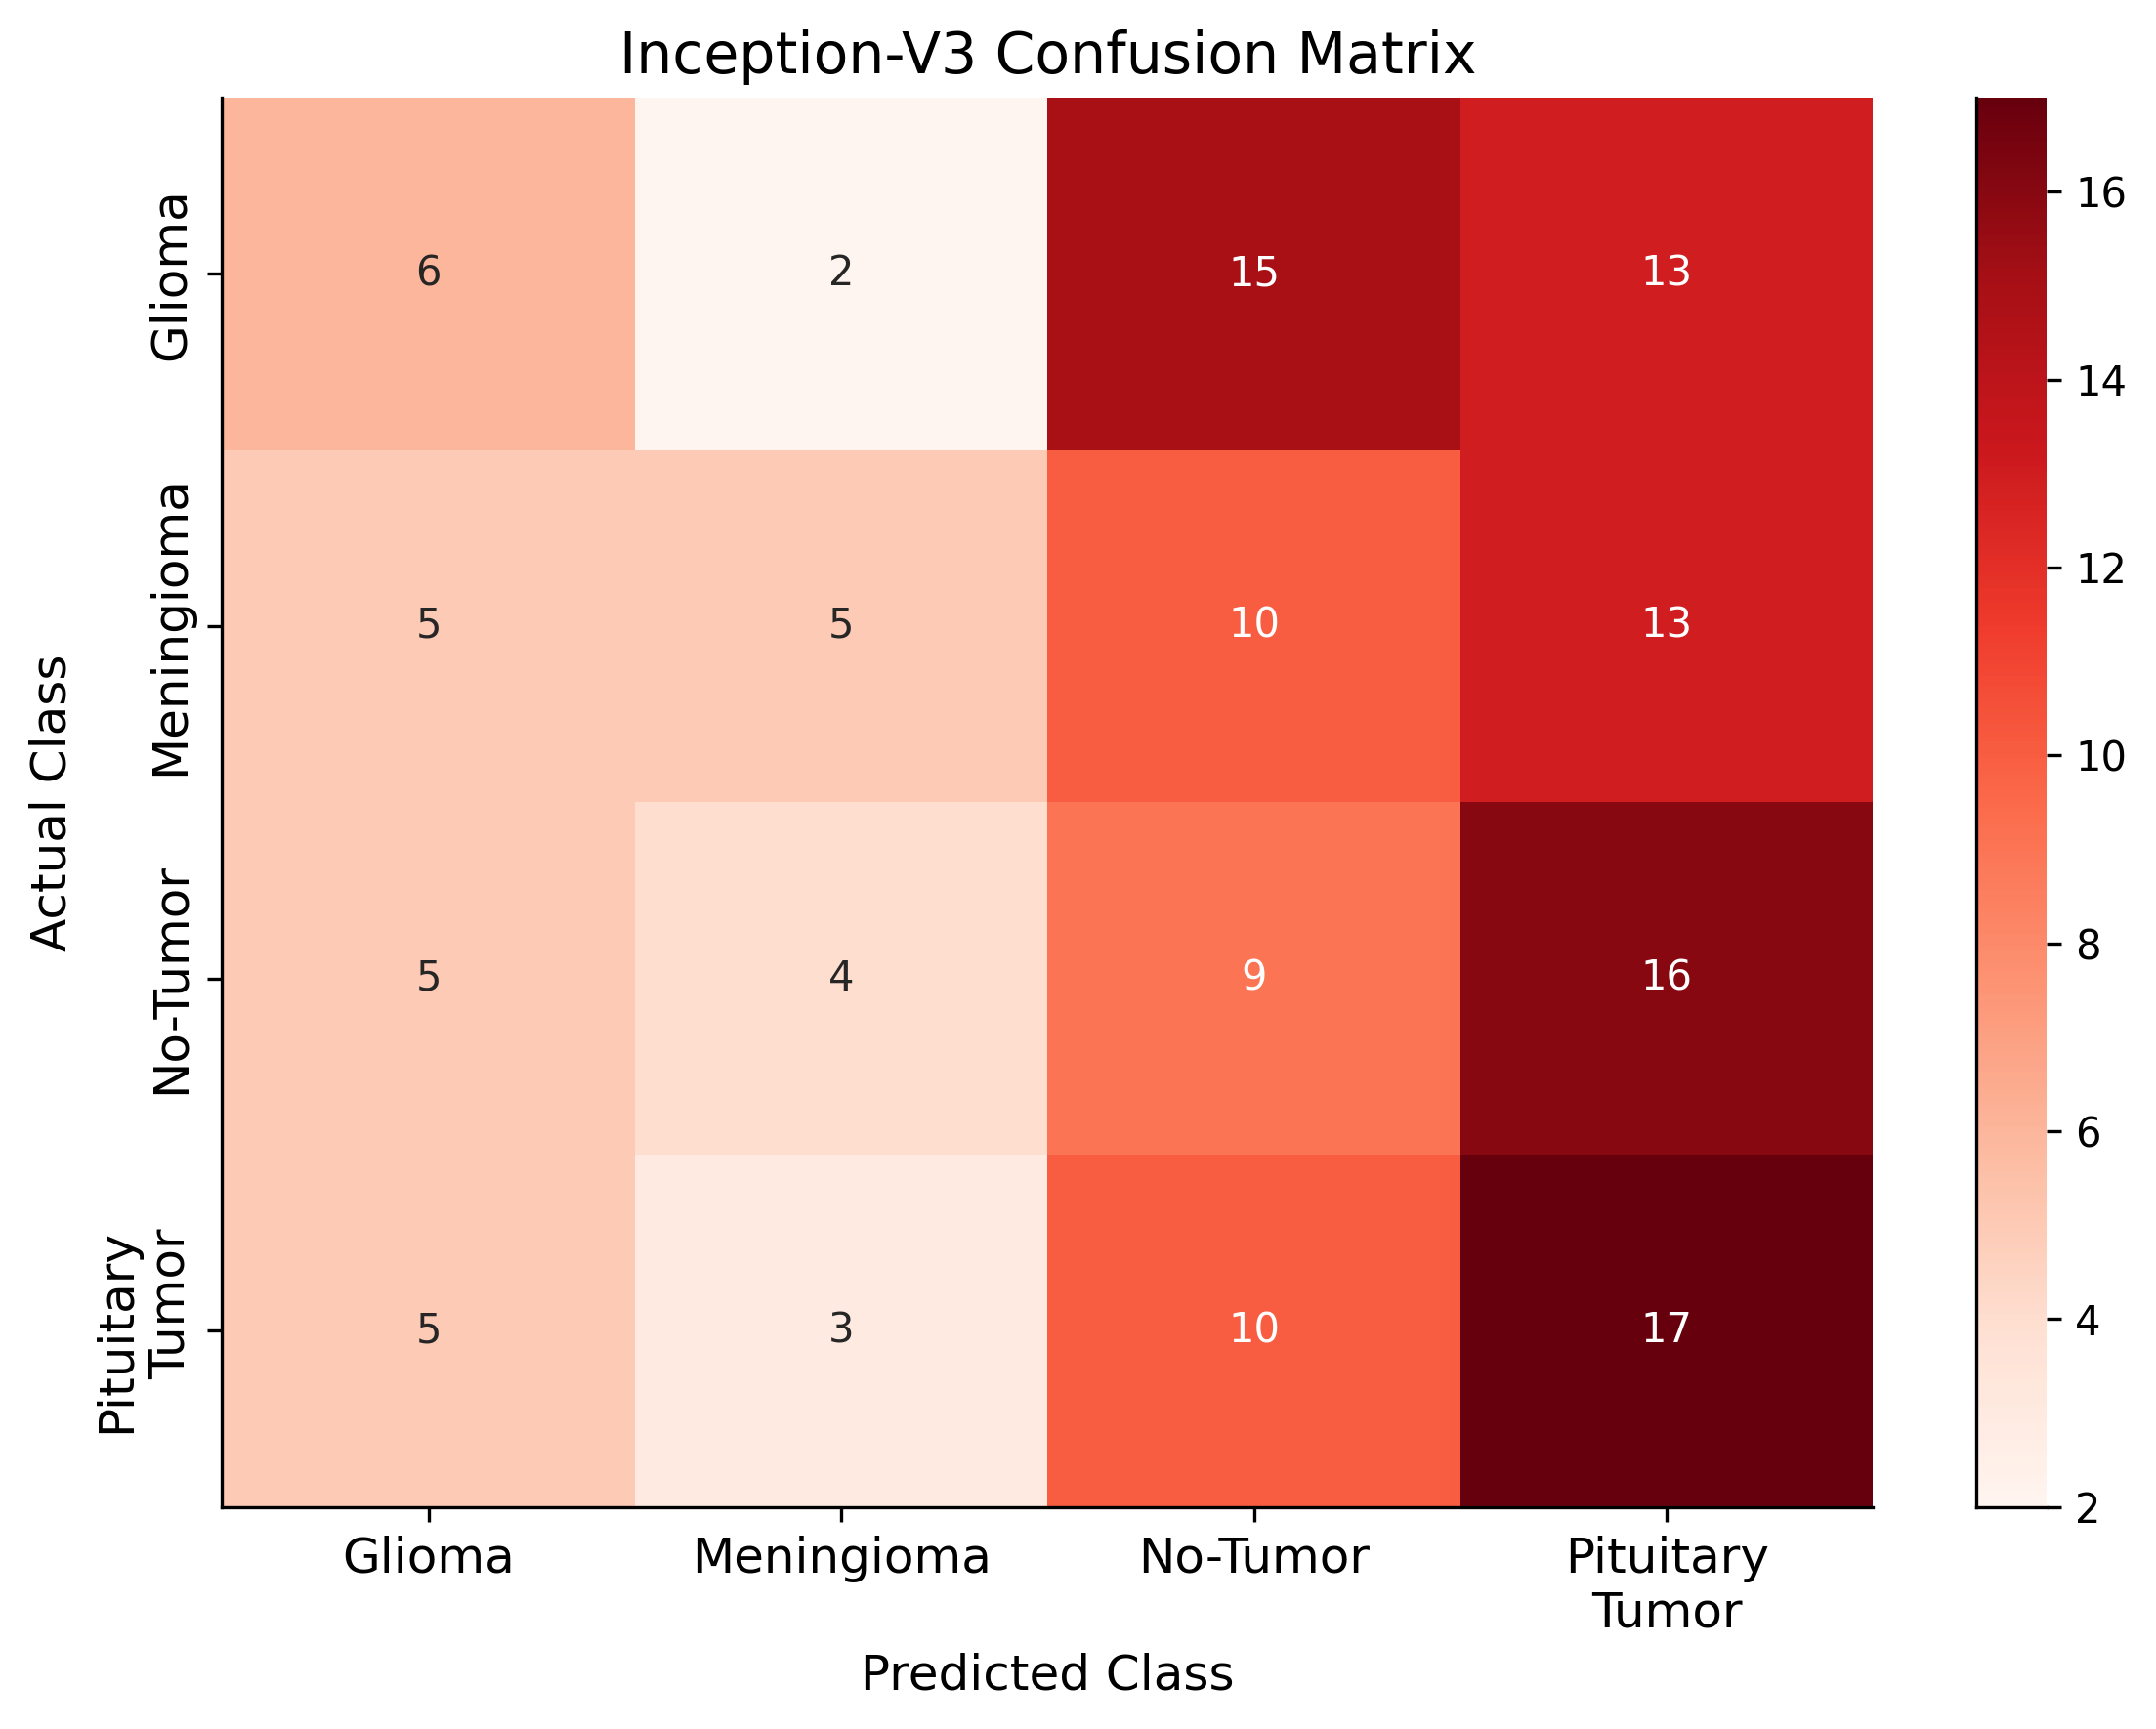

In [35]:
with tf.device(device):
    confusion_matrix_viz(inception_cnn_model, test_dataset, plot_title="Inception-V3 Confusion Matrix")


In [36]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset=test_dataset, row_indexes=['InceptionV3'])
print(inceptionv3_report_df)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6866 - loss: 1.0626
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
                  MAE       MSE     RMSE      Loss  Accuracy  F1-Score
InceptionV3  1.369565  2.847826  1.68755  1.478722  0.666667  0.217391
